Google Analytics is one of the main resources used in digital marketing field to view reports. However, if you require deeper analysis using Machine Learning or Deep Learning, we can use R or Python to extract the data from Google Analytics

We can extract the data from Google Analytics through an API in Python. Below are the steps:

1. First step is to create a project in google developer console and obtain the client id, client secret and also enable the Google Analytics Reporting API and Analytics API.

2. The next step involves obtaining permission from the gmail account that has access to google analytics accounts. Thereafter Google will be providing a unique refresh token. Using the unique refresh token, Google analytics data belonging to the gmail account can be obtained.

#### Importing Library

In [1]:
from oauth2client.client import OAuth2WebServerFlow
from oauth2client.tools import run_flow
from oauth2client.file import Storage
import json
import os
import re
import httplib2 
from oauth2client import GOOGLE_REVOKE_URI, GOOGLE_TOKEN_URI, client
import requests
import pandas as pd

#### Function to check if the file exist in the directory

In [2]:
def where_json(file_name):
    """function check whether file exist in the path or not"""
    return os.path.exists(file_name)

#### Function to get the refresh token

In [3]:
def get_refresh_token(client_id,client_secret):
    """ This function returns the refresh token"""
    CLIENT_ID = client_id
    CLIENT_SECRET = client_secret
    SCOPE = 'https://www.googleapis.com/auth/analytics.readonly'
    REDIRECT_URI = 'http:localhost:8080'
  
    flow = OAuth2WebServerFlow(client_id=CLIENT_ID,client_secret=CLIENT_SECRET,scope=SCOPE,redirect_uri=REDIRECT_URI)
    if where_json('credential.json')==False:
       storage = Storage('credential.json') 
       credentials = run_flow(flow, storage)
       refresh_token=credentials.refresh_token
       
    elif where_json('credential.json')==True:
       with open('credential.json') as json_file:  
           data         = json.load(json_file)
       refresh_token=data['refresh_token']
  
    return(refresh_token)


#### Using the client id and client secret that was obtained from the project when we created to get refresh token

In [4]:
client_id = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
client_secret = 'XXXXXXXXXXXXXX'
refresh_token=get_refresh_token(client_id,client_secret)

#### Now we have the refresh token to access the google analytics data. However to access the data we need one more parameter which is the view id of the particular google analytics account. 

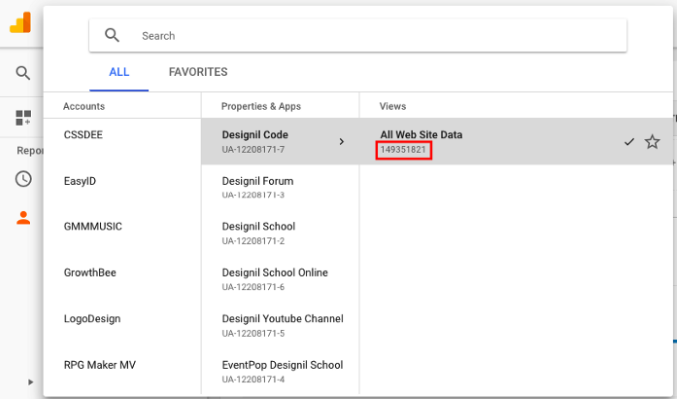

Once we have the client id, client secret, refresh token and view id with us, Google analytics data can be obtained by using the following function given below

In [6]:
def google_analytics_reporting_api_data_extraction(viewID,dim,met,start_date,end_date,refresh_token,transaction_type,goal_number,condition):
    ''' function return the google analytics data for given dimension, metrics, start data, end data access token, type,goal number, condition'''
    viewID=viewID;dim=dim;met=met;start_date=start_date;end_date=end_date;refresh_token=refresh_token;transaction_type=transaction_type;condition=condition
    goal_number=goal_number
    viewID="".join(['ga%3A',viewID])
    
    if transaction_type=="Goal":
        met1="%2C".join([re.sub(":","%3A",i) for i in met]).replace("XX",str(goal_number))
    elif transaction_type=="Transaction":
        met1="%2C".join([re.sub(":","%3A",i) for i in met])
        
    dim1="%2C".join([re.sub(":","%3A",i) for i in dim])
    
    if where_json('credential.json')==True:
       with open('credential.json') as json_file:  
           storage_data = json.load(json_file)
       
       client_id=storage_data['client_id']
       client_secret=storage_data['client_secret']
       credentials = client.OAuth2Credentials(
                access_token=None, client_id=client_id, client_secret=client_secret, refresh_token=refresh_token,
                token_expiry=3600,token_uri=GOOGLE_TOKEN_URI,user_agent='my-user-agent/1.0',revoke_uri=GOOGLE_REVOKE_URI)

       credentials.refresh(httplib2.Http())
       rt=(json.loads(credentials.to_json()))['access_token']
  
       api_url="https://www.googleapis.com/analytics/v3/data/ga?ids="
    
       url="".join([api_url,viewID,'&start-date=',start_date,'&end-date=',end_date,'&metrics=',met1,'&dimensions=',dim1,'&max-results=1000000',condition,'&access_token=',rt])
    
       data=pd.DataFrame()
    
       try:
         r = requests.get(url)
                
         try:
            data=pd.DataFrame(list((r.json())['rows']),columns=[re.sub("ga:","",i) for i in dim+met])
            data['date']=start_date
            print("data extraction is successfully completed")
           
            return data
         except:
            print((r.json()))
       except:
         print((r.json()))
         print("error occured in the google analytics reporting api data extraction")

Now we have all parameters to extract the data. Here we need to keep in mind while passing dimensions (dim) and metrics (met) is you have to pass them as a list.

There are 2 transaction type values that is Transaction or goal. If a transaction type is Transaction then goal_number is ‘ ’(blank quote). If the transaction type is a Goal then goal_number is a numerical value (eg: 1,2,3,…,20). The Condition is thereby sorted by a metric [eg: &sort=-ga%3Ausers (sort by users descending order),&sort=-ga%3Ausers (sort by user ascending order), etc]

**Scenario 1:** When Transaction type is ‘Transaction’ and without a condition

In [8]:
viewID='XXXXXXXX'
dim=['ga:browser','ga:sourceMedium']
met=['ga:users','ga:revenuePerTransaction']
start_date='2019-01-01'
end_date='2019-01-10'
transaction_type='Transaction'
goal_number=''
refresh_token=refresh_token
condition=''

data=google_analytics_reporting_api_data_extraction(viewID,dim,met,start_date,end_date,refresh_token,transaction_type,goal_number,condition)

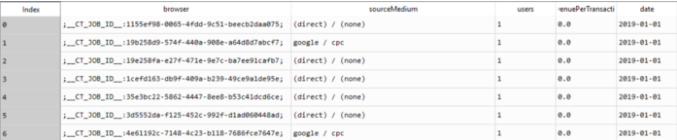

**Scenario 2:** When Transaction type is ‘Transaction’ and has a condition

In [9]:
viewID='XXXXXXXX'
dim=['ga:browser','ga:sourceMedium']
met=['ga:users','ga:revenuePerTransaction']
start_date='2019-01-01'
end_date='2019-01-10'
transaction_type='Transaction'
goal_number=''
refresh_token=refresh_token
condition='&sort=-ga%3Ausers' # sort the data set by users in descending order

data=google_analytics_reporting_api_data_extraction(viewID,dim,met,start_date,end_date,refresh_token,transaction_type,goal_number,condition)

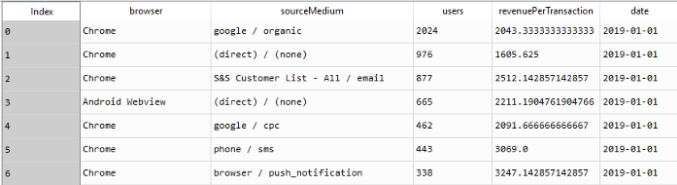

**Scenario 3:** When Transaction type is ‘Goal’ and without a condition

If you have already setup the goals in your google analytics account, you can access.

In [11]:
viewID='XXXXXXXX'
dim=['ga:browser','ga:sourceMedium']
met=['ga:users','ga:goalXXCompletions']
start_date='2019-01-01'
end_date='2019-01-10'
transaction_type='Goal'
goal_number=''
refresh_token=refresh_token
condition=''

data=google_analytics_reporting_api_data_extraction(viewID,dim,met,start_date,end_date,refresh_token,transaction_type,goal_number,condition)

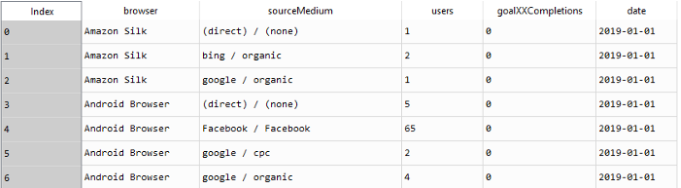

**Scenario 4:** When Transaction type is ‘Goal’ and has a condition

In [12]:
viewID='XXXXXXXX'
dim=['ga:browser','ga:sourceMedium']
met=['ga:users','ga:goalXXCompletions']
start_date='2019-01-01'
end_date='2019-01-10'
transaction_type='Goal'
goal_number='1'
refresh_token=refresh_token
condition='&sort=-ga%3Ausers' 
# sort the data set by users in descending order

data=google_analytics_reporting_api_data_extraction(viewID,dim,met,start_date,end_date,refresh_token,transaction_type,goal_number,condition)

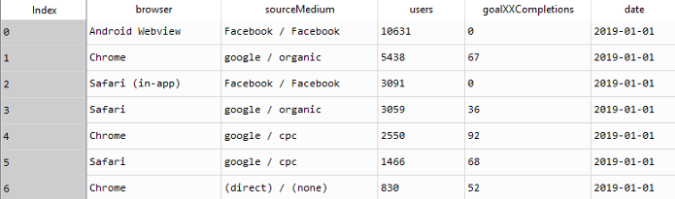